In [1]:
# import the necessary packages
import os
# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH = "data"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "aipo_train"])
#IMAGES_TEST_PATH = os.path.sep.join([BASE_PATH, "aipo_test"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "train_df.csv"])

In [2]:
# define the path to the base output directory
BASE_OUTPUT = "data/output"
# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])

In [3]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 32

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import os

do poprawy

In [5]:
# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(ANNOTS_PATH).read().strip().split("\n")
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
filenames = []

[INFO] loading dataset...


In [6]:
# loop over the rows
for row in rows:
    # break the row into the filename and bounding box coordinates
    row = row.split(",")
    (filename, startX, endX, startY, endY, _) = row
    # derive the path to the input image, load the image (in OpenCV
    # format), and grab its dimensions
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]
    # scale the bounding box coordinates relative to the spatial
    # dimensions of the input image
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h
    # load the image and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)

In [7]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]
# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(TEST_FILENAMES, "w+")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


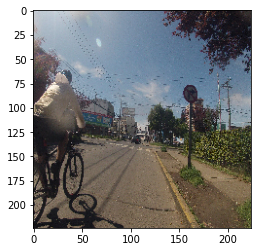

In [8]:
img = trainImages[3]
#startX = int(trainTargets[0][0])
#startY = int(trainTargets[0][1])
#endX = int(trainTargets[0][2])
#endY = int(trainTargets[0][3])
#startX = int(trainTargets[3][0]*224)
#startY = int(trainTargets[3][1]*224)
#endX = int(trainTargets[3][2]*224)
#endY = int(trainTargets[3][3]*224)
#print(startX)
#(startX, startY, endX, endY) = 
#cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)
plt.imshow(img)
plt.show()

In [11]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
#vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(1024, activation="relu")(flatten)
bboxHead = BatchNormalization()(bboxHead)
bboxHead = Dense(1024, activation="relu")(bboxHead)
bboxHead = Dropout(0.2)(bboxHead)
bboxHead = Dense(512, activation="relu")(bboxHead)
bboxHead = Dense(512, activation="relu")(bboxHead)
bboxHead = Dropout(0.1)(bboxHead)
bboxHead = Dense(256, activation="relu")(bboxHead)
bboxHead = Dense(128, activation="relu")(bboxHead)
bboxHead = Dropout(0.1)(bboxHead)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In [8]:
model = load_model(MODEL_PATH)

Metal device set to: Apple M1


2022-07-03 21:38:56.107496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-03 21:38:56.107614: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# initialize the optimizer, compile the model, and show the model
# summary
#opt = Adam(lr=INIT_LR)
#model.compile(loss="mse", optimizer=opt)
checkpointer = ModelCheckpoint(filepath=os.path.sep.join([BASE_OUTPUT, "model_best.h5"]), monitor="loss", save_best_only=True)
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
trainImages, trainTargets,
validation_data=(testImages, testTargets),
batch_size=BATCH_SIZE,
epochs=25,
verbose=1,
callbacks=[checkpointer])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

2022-07-03 21:38:57.126419: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-03 21:38:57.373432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - ETA: 0s - loss: 0.0015

2022-07-03 21:39:43.326664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 48s 2s/step - loss: 0.0015 - val_loss: 0.0020
Epoch 2/25
23/23 [==============================] - 47s 2s/step - loss: 0.0029 - val_loss: 0.0030
Epoch 3/25
23/23 [==============================] - 47s 2s/step - loss: 0.0031 - val_loss: 0.0101
Epoch 4/25
23/23 [==============================] - 48s 2s/step - loss: 0.0040 - val_loss: 0.0084
Epoch 5/25
23/23 [==============================] - 47s 2s/step - loss: 0.0038 - val_loss: 0.0059
Epoch 6/25
23/23 [==============================] - 47s 2s/step - loss: 0.0035 - val_loss: 0.0058
Epoch 7/25
23/23 [==============================] - 47s 2s/step - loss: 0.0015 - val_loss: 0.0044
Epoch 8/25
23/23 [==============================] - 48s 2s/step - loss: 8.4565e-04 - val_loss: 0.0038
Epoch 9/25
23/23 [==============================] - 48s 2s/step - loss: 6.5810e-04 - val_loss: 0.0039
Epoch 10/25
23/23 [==============================] - 48s 2s/step - loss: 5.7913e-04 - val_loss: 0.0032
Epoch 11/25
23/23 

In [10]:
model.save(MODEL_PATH, save_format="h5")

In [ ]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# plot the model training history
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)